In [1]:
import lightkurve as lk
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import light_curve as lc
from astroquery.vizier import Vizier

%matplotlib inline

In [2]:
FLARE_AMPLITUDE = 0.1
AUTHOR = 'SPOC'
CATALOG_ID = 'J/AJ/159/60/table1'
COLUMNS = ['TIC', 'tpeak', 'Amp', 'Sec', 'e_tpeak', 'E_tpeak', 'FWHMdt']

In [31]:
# random generator setting

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
# got flares data from vizier

v = Vizier(columns=COLUMNS)
v.ROW_LIMIT = 9999999

res = v.query_constraints(CATALOG_ID)
tess_flares = res[0]

tess_flares = tess_flares[tess_flares['Amp'] > FLARE_AMPLITUDE].to_pandas()

In [5]:
from bisect import bisect

def getFlare(flare_meta):
    
    tic = int(flare_meta['TIC'])
    sector = int(flare_meta['Sec'])
    amp = flare_meta['Amp']
    fwhm = flare_meta['FWHMdt']
    
    light_curve = lk.search_lightcurve(f'TIC{tic}', author=AUTHOR, sector=sector).download()

    flare_time = Time(flare_meta['_tab2_5'], format='jd')
    fwhm = flare_meta['FWHMdt']

    flare = light_curve[(light_curve['time'].mjd <= flare_time.mjd + 0.5) & (light_curve['time'].mjd >= flare_time.mjd - 0.5)]
        
    mag = -2.5 * np.log10(np.array(flare.flux))
    
    nonzero = flare.flux.nonzero()
    flare = flare[nonzero]
    
    # check if the flare in the nonzero array
    flare_idx = np.searchsorted(flare.time, flare_time)
    
    if flare_idx == len(flare.time) or flare_idx == 0:
        return [tic, None, None, None]
    
    return [tic, flare.time.mjd, flare.flux, flare.flux_err, flare_time.mjd]

In [36]:
# CODE TO GENERATE A CSV TABLE WITH TESS TEMPLATES
# IT TAKES RATHER A LONG TIME (about ~50 minutes)

# templates_df = pd.concat([pd.DataFrame([getFlare(row)], 
#                           columns=['TIC', 'mjd', 'flux', 'flare_time']) for _, row in tess_flares.iterrows()], 
#                           ignore_index=True)
# templates_df.to_csv('tess_templates.csv', index=False)

In [6]:
import ast

def from_np_array(array_string):
    if not isinstance(array_string, str):
        return array_string
    
    array_string = array_string.replace('electron / s', '')
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [7]:
templates_df = pd.read_csv('tess_templates.csv')

templates_df['flux'] = templates_df['flux'].map(lambda x: from_np_array(x))
templates_df['mjd'] = templates_df['mjd'].map(lambda x: from_np_array(x))

templates_df = templates_df[templates_df['flare_time'].notnull()]

In [8]:
distributions = pd.read_csv('filter_mag_magerr_nolim.csv', names=['n', 'mag', 'magerr', 'filter'])

In [9]:
mag_filter1 = distributions[distributions['filter'] == 1].groupby('mag', as_index = False)['n'].sum()
mag_filter2 = distributions[distributions['filter'] == 2].groupby('mag', as_index = False)['n'].sum()
mag_filter3 = distributions[distributions['filter'] == 3].groupby('mag', as_index = False)['n'].sum()

In [10]:
from scipy.interpolate import interp1d

def genMagerr(filter, mag):
    distr = distributions[distributions['filter'] == filter]
    sorted_mag = np.sort(distr['mag'])
    bin_idx = np.searchsorted(sorted_mag, mag)

    bin_mag = sorted_mag[bin_idx-1]

    distr = distr[distr['mag'] == bin_mag].groupby('magerr', as_index = False)['n'].sum()
    
    bins = np.arange(min(distr['magerr']), max(distr['magerr']), 0.05)
    bins_map = dict.fromkeys(bins, 0)
    
    for i in range(distr.shape[0]):
        magerr = distr.iloc[i]['magerr']
        q = distr.iloc[i]['n']
        bins_map[magerr] = q
    
    cdf = np.cumsum(list(bins_map.values()))
        
    cdf = cdf / cdf[-1]
    u = rng.uniform(min(cdf), 1)
    
    func_interp = interp1d(cdf, list(bins_map.keys()))
    samples = func_interp(u)
    
    return samples

In [11]:
import itertools

def find_closest(array, x):
    return np.argmin(np.abs(array - x))

def get2dHist(filter, bins_mag, bins_sigma, counts, n_x, n_y):
    keys = [(x, y) for x, y in zip(bins_mag, bins_sigma)]
    hist_dict = {k:v for k, v in zip(keys, counts)}
    
    xedge = np.linspace(min(bins_mag), max(bins_mag), n_x)
    yedge = np.linspace(min(bins_sigma), max(bins_sigma), n_y)
    
    true_keys = list(itertools.product(xedge, yedge))
    true_dict = np.zeros((n_x, n_y))

    for (x, y), count in hist_dict.items():
            i = find_closest(xedge, x)
            j = find_closest(yedge, y)
            
            true_dict[i, j] = count    
            
    plt.pcolormesh(yedge, xedge, true_dict)
    plt.xlabel('sigma')
    plt.ylabel('mag')
    plt.title(f'filter {filter}')
    
    return xedge, yedge, true_dict

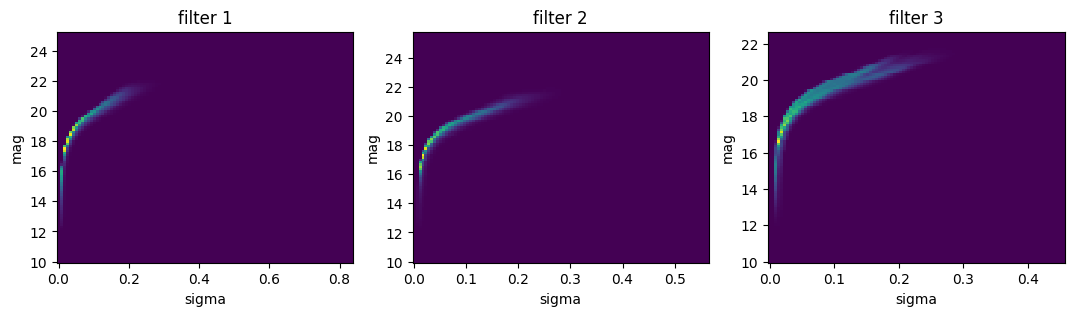

In [12]:
plt.figure(figsize=(13, 3))

plt.subplot(131)
distr_filter = distributions[distributions['filter'] == 1]

xedge, yedge, counts = get2dHist(1, distr_filter['mag'].to_numpy(), 
                                    distr_filter['magerr'].to_numpy(), 
                                    distr_filter['n'].to_numpy(), 100, 100)


plt.subplot(132)
distr_filter = distributions[distributions['filter'] == 2]

xedge, yedge, counts = get2dHist(2, distr_filter['mag'].to_numpy(), 
                                    distr_filter['magerr'].to_numpy(), 
                                    distr_filter['n'].to_numpy(), 100, 100)

plt.subplot(133)
distr_filter = distributions[distributions['filter'] == 3]

xedge, yedge, counts = get2dHist(3, distr_filter['mag'].to_numpy(), 
                                    distr_filter['magerr'].to_numpy(), 
                                    distr_filter['n'].to_numpy(), 100, 100)

In [13]:
'''
Function, which returns interpolated CDF for the required filter
'''

def genMagCdf(filter, plot_hist=False):
    statistics = [mag_filter1, mag_filter2, mag_filter3]
    stats = statistics[filter-1]

    bins = np.arange(min(stats['mag']), max(stats['mag']), 0.1)
    bins_map = dict.fromkeys(bins, 0)

    for i in range(stats.shape[0]):
        mag = stats.iloc[i]['mag']
        q = stats.iloc[i]['n']
        bins_map[mag] = q

    if plot_hist:
        bins = list(bins_map.values())
        plt.stairs(bins[:-1], list(bins_map.keys()), fill=True)
        plt.xlabel('magnitude')
        plt.ylabel('n')
        plt.title(f'filter = {filter}')
        
    cdf = np.cumsum(list(bins_map.values()))
    cdf = cdf / cdf[-1]

    func_interp = interp1d(cdf, list(bins_map.keys()))

    return func_interp

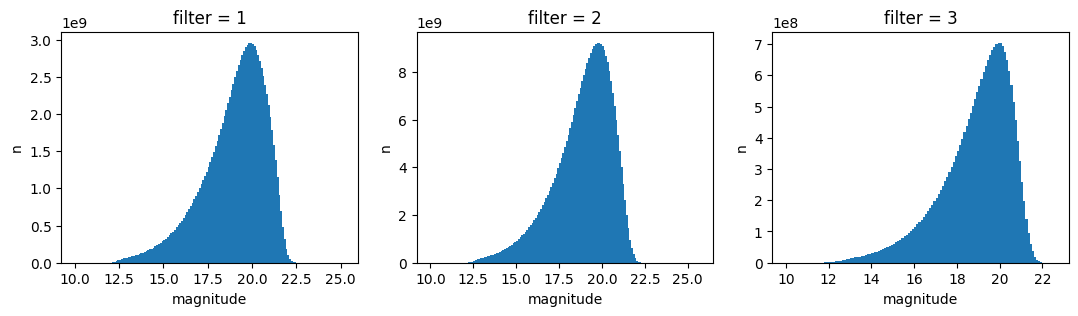

In [14]:
plt.figure(figsize=(13, 3))
plt.subplot(131)
genMagCdf(1, plot_hist=True)
plt.subplot(132)
genMagCdf(2, plot_hist=True)
plt.subplot(133)
genMagCdf(3, plot_hist=True)

In [15]:
cdf_filter1 = genMagCdf(1)
cdf_filter2 = genMagCdf(2)
cdf_filter3 = genMagCdf(3)

cdf = [cdf_filter1, cdf_filter2, cdf_filter3]

In [16]:
'''
Returns sampled magnitude from precalculated CDF
'''

def genMagnitude(n, filter):
    u = rng.uniform(0, 1, n)
    
    func_interp = cdf[filter-1]
    samples = func_interp(u)
    
    return samples

In [18]:
from ast import literal_eval

ztf_cadence = pd.read_csv('ztf_cadence.csv', names=['duration', 'split', 'len', 'oid', 'filter', 'mjd'], index_col=None)
ztf_cadence['mjd'] = ztf_cadence['mjd'].map(lambda x: np.array(literal_eval(x)))

In [26]:
from scipy.interpolate import interp1d

def flux2Mag(flux):
    mag = -2.5 * np.log10(flux) 
    return mag

def getZtfLc(lc):
    t = lc['mjd'].to_numpy()[0].copy()
    flux = lc['flux'].to_numpy()[0].copy()
    flare_time = lc['flare_time'].to_numpy()[0].copy()
        
    cadence = ztf_cadence.sample(random_state=rng)
    
    cad = cadence['mjd'].to_numpy()[0]
    filter = cadence['filter'].to_numpy()[0]
    oid = cadence['oid'].to_numpy()[0]
    
    ztf_t = cad.copy()
    
    normalize = min(ztf_t) - min(t)
    flare_time += normalize
    t += normalize

    time_after_flare = max(t) - flare_time
    time_before_flare = flare_time - min(t)

    # we shoul check if time before/after flare point
    # is less than the full cadence duration and adjust offset's interval according to it
    
    if time_after_flare < (max(ztf_t) - min(ztf_t)):
        a = flare_time
    else:
        a = min(ztf_t)
        
    if time_before_flare < (max(ztf_t) - min(ztf_t)):
        b = flare_time
    else:
        b = max(ztf_t)
    
    if a > b:
        a, b = b, a
    
    offset = rng.uniform(a, b)
    off = offset - flare_time
    off_t = t + off
        
    f = interp1d(off_t, flux / min(flux))
    
    star_magnitude = genMagnitude(1, filter)
    mag_f = lambda x: flux2Mag(f(x)) + star_magnitude
    mag = np.array(mag_f(ztf_t))
    sigma = np.array([genMagerr(filter, i) for i in mag])
    
    return (np.array(cad), mag + rng.normal(size=len(cad)) * sigma, sigma, cadence.index[0], flare_time, filter, oid) 

In [44]:
generated_objects = pd.DataFrame(columns=['TIC', 'mjd', 'mag', 'magerr', 'flare_time', 'chi2', 'cadence_id', 'cadence_filter', 'cadence_oid'])

In [20]:
def generateZtfFlare(n):
    redchi2 = lc.ReducedChi2()
    row_array = []
    #generated_objects = pd.DataFrame(columns=['TIC', 'mjd', 'mag', 'magerr', 'flare_time', 'chi2', 'cadence_id', 'cadence_filter', 'cadence_oid'])
    
    for i in range(n):

        flare = templates_df.sample(random_state=rng)
        tic = flare['TIC'].values[0]
        
        mjd, mag, magerr, cadence_index, flare_time, cadence_filter, cadence_oid = getZtfLc(flare)
        val = redchi2(mjd, mag, np.array(magerr))
        row = [[tic, mjd, mag, magerr, flare_time, val[0], cadence_index, cadence_filter, cadence_oid]]
        row_array.append(row)
        
        # generated_objects = pd.concat([generated_objects, pd.DataFrame(row, columns=['TIC',
        #                                                                             'mjd', 
        #                                                                             'mag', 
        #                                                                             'magerr', 
        #                                                                             'flare_time', 
        #                                                                             'chi2',
        #                                                                             'cadence_id',
        #                                                                             'cadence_filter',
        #                                                                             'cadence_oid'])])
        
        
    return row_array
        

In [78]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=18, timeout=999999)(delayed(generateZtfFlare)(150) for i in range(1000))

/home/lavrukhina/lavrukhina_env3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [79]:
generated_objects = pd.DataFrame(np.array(results, dtype=object).reshape(150000, 9))

In [80]:
generated_objects.to_csv('generated_150k.csv')

In [500]:
CHI_LIMIT = 3

In [137]:
mean = generated_objects['mag'].map(lambda x: np.mean(x))

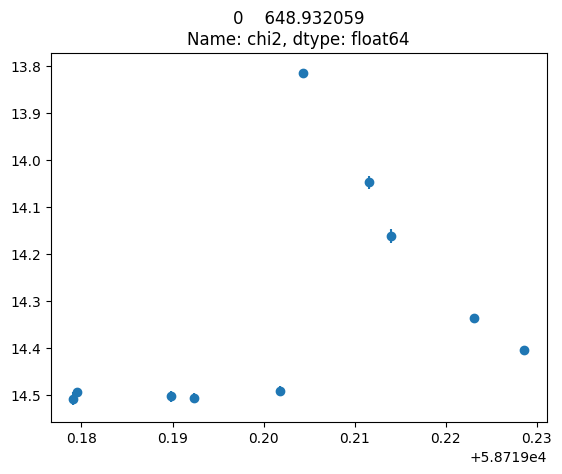

In [523]:
random = generated_objects[generated_objects['chi2'] > CHI_LIMIT].sample()

plt.errorbar(random['mjd'].to_numpy()[0], random['mag'].to_numpy()[0], random['magerr'].to_numpy()[0], fmt='o')
plt.title(str(random['chi2']))
plt.gca().invert_yaxis()  

In [9]:
import ast

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [10]:
generated_objects = pd.read_csv('generated_250k.csv', 
                                converters={'mjd': from_np_array, 'mag': from_np_array, 'magerr': from_np_array},
                                index_col=False)

In [158]:
generated_objects.to_csv('generated_flare_250k.csv')

In [160]:
pd.read_csv('generated_flare_250k.csv', converters={'mjd': from_np_array, 'mag': from_np_array, 'magerr': from_np_array})

,Unnamed: 0,TIC,mjd,mag,magerr,flare_time,chi2,cadence_id
0,0,401838575,"[58670.22392, 58670.22437, 58670.23171, 58670....","[18.93377643, 18.92693795, 19.00985149, 18.901...","[0.06915677, 0.04368783, 0.05546116, 0.0469365...",58670.723244,6.771148,210139
1,1,229137237,"[58806.40329, 58806.40373, 58806.40419, 58806....","[18.44983858, 18.42632196, 18.53543563, 18.453...","[0.03816467, 0.03277796, 0.04178508, 0.0351525...",58806.901907,3.640815,48965
2,2,332517282,"[58726.17404, 58726.18414, 58726.19523, 58726....","[19.44587903, 19.30531509, 19.32871613, 19.300...","[0.0738861, 0.06057421, 0.05880634, 0.05329344...",58726.673042,2.153495,93224
3,3,339607562,"[58867.27681, 58867.27726, 58867.27771, 58867....","[16.17774176, 16.16988355, 16.18240478, 16.180...","[0.01113228, 0.01237234, 0.01352517, 0.0131262...",58867.776362,2.829389,35478
4,4,160113240,"[58719.1751, 58719.17555, 58719.19013, 58719.1...","[15.73534893, 15.72950935, 15.78411225, 15.781...","[0.01236958, 0.01081624, 0.01256477, 0.0229319...",58719.674024,4.621342,194336
...,...,...,...,...,...,...,...,...
252796,252796,302296434,"[58468.09283, 58468.09329, 58468.09374, 58468....","[17.18965567, 17.14352202, 17.1644606, 17.2004...","[0.01589039, 0.0162306, 0.01590003, 0.01871675...",58468.592005,2.607492,37118
252797,252797,382243958,"[58719.17305, 58719.1735, 58719.18731, 58719.1...","[18.96821121, 19.07609905, 18.92866044, 19.102...","[0.05509176, 0.04845715, 0.0962942, 0.06836221...",58719.672071,4.316107,69586
252798,252798,206609630,"[58287.35417, 58287.35462, 58287.35553, 58287....","[17.78263288, 17.79559713, 17.76414208, 17.745...","[0.05447452, 0.02552808, 0.02042474, 0.0271241...",58287.853816,1.852205,201325
252799,252799,77041173,"[58348.21776, 58348.22511, 58348.2265, 58348.2...","[20.56980414, 21.23658742, 20.85382301, 20.745...","[0.20837597, 0.18824113, 0.14989662, 0.1914626...",58348.716667,9.461826,156054
